In [1]:
import tensorflow as tf

import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import random

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import dataset_util
%matplotlib inline

Loading the model

In [5]:
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
print(configs)

{'model': ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.0004
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.03
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.997
        scale: true
        epsilon: 0.001
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: false
      negatives_lower_than_unmatched: true
  

In [77]:
detection_model = model_builder.build(model_config=model_config, is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(checkpoint_path).expect_partial()

In [6]:
num_classes = 1
model_config.ssd.num_classes = num_classes
detection_model = model_builder.build(model_config=model_config, is_training=True)
# load everything except for the classification head
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

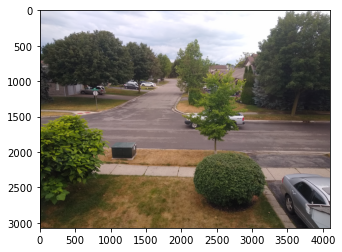

In [78]:
image_path = pathlib.Path('models/research/object_detection/test_images')
test_images = sorted(list(image_path.glob("*.jpg")))
image = load_to_nparray(test_images[3])
input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
plt.imshow(image)
plt.show()

In [18]:
def load_to_nparray(im_path):
    image = Image.open(im_path)
    array = np.array(image)
    return array

def get_detection_function(model):
    @tf.function
    def detect(tensor):
        preprocessed_image, shapes = model.preprocess(tensor)
        prediction_dict = model.predict(preprocessed_image, shapes)
        return model.postprocess(prediction_dict, shapes)
    return detect

def get_train_function(model,optimizer,vars_to_tune):
    
    @tf.function
    def train_step(image_tensors,gt_boxes,gt_classes):
        batch_size = min(len(image_tensors),len(gt_boxes),len(gt_classes))
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes,
            groundtruth_classes_list=gt_classes)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_tune))
        return total_loss
    return train_step


def train_model(train_fn,images,gt_boxes,gt_classes,batch_size,epochs):
    length = min(len(images),len(gt_boxes),len(gt_classes))
    print(length)
    batch_num = length//batch_size
    keys = list(range(length))
    for i in range(epochs):
        random.shuffle(keys)
        for j in range(batch_num):
            image_list = [images[key] for key in keys[batch_size*j:batch_size*(j+1)]]
            box_list = [gt_boxes[key] for key in keys[batch_size*j:batch_size*(j+1)]]
            class_list = [gt_classes[key] for key in keys[batch_size*j:batch_size*(j+1)]]

            loss = train_fn(image_list,box_list,class_list)


            print("loss at epoch "+str(i)+", batch "+str(j)+"/"+str(batch_num)+" : " +str(loss.numpy()))

            
def prepare_data(images,boxes,classes,num_classes):
    image_tensors = []
    gt_box_tensors = []
    gt_class_tensors = []
    for (image, box, cls) in zip(images,boxes,classes):
        image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
            image, dtype=tf.float32), axis=0))
        gt_box_tensors.append(tf.convert_to_tensor(box, dtype=tf.float32))
        gt_class_tensors.append(tf.one_hot(cls,num_classes))
    
    return image_tensors, gt_box_tensors, gt_class_tensors
    
    
def get_boxes(box_dir,extension="png"):
    box_path = pathlib.Path(box_dir)
    box_paths = sorted(list(box_path.glob("*."+extension)))
    
    boxes = []
    cls_gt = []
    
    for b in box_paths:
        mask = load_to_nparray(b)
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        image_boxes=[]
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            image_boxes.append([xmin, ymin, xmax, ymax])

        boxes.append(image_boxes)
 
        labels = tf.ones((num_objs,), dtype=tf.int64)
        cls_gt.append(labels)

    return boxes, cls_gt

    
    

In [81]:
detect = get_detection_function(detection_model)
detections = detect(input_tensor)
print(detections)

{'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[0.73930335, 0.826932  , 1.        , 0.9997639 ],
        [0.32943368, 0.3456374 , 0.35672694, 0.40279076],
        [0.47531483, 0.6516532 , 0.5270321 , 0.7077967 ],
        [0.35336092, 0.13219082, 0.3918188 , 0.23045799],
        [0.33108124, 0.2903006 , 0.3645964 , 0.3413326 ],
        [0.46671304, 0.5007229 , 0.5428386 , 0.7052965 ],
        [0.47686356, 0.0017084 , 0.9169355 , 0.23441283],
        [0.36115602, 0.18390287, 0.43455002, 0.20015268],
        [0.35148135, 0.1771523 , 0.3897914 , 0.2267684 ],
        [0.47531483, 0.6516532 , 0.5270321 , 0.7077967 ],
        [0.35439137, 0.13787328, 0.38885996, 0.20323451],
        [0.46671304, 0.5007229 , 0.5428386 , 0.7052965 ],
        [0.36052296, 0.15531313, 0.3945634 , 0.20892447],
        [0.32888335, 0.2968394 , 0.35437936, 0.33831885],
        [0.35194215, 0.19479653, 0.38925305, 0.22930256],
        [0.34983864, 0.19281943, 0.37286308, 0.2232338 ],

In [19]:
def get_images(image_dir,extension="png"):
    path = pathlib.Path(image_dir)
    paths = sorted(list(path.glob("*."+extension)))
    images = []
    for i in paths:
        encoded_image = tf.io.gfile.GFile(str(i)).read()
        image = Image.open(i)
        width, height = image.size
        images.append((encoded_imag,image,pathlib.Path(i).stem,width,height))
        
    return images
    
    
images = get_images('PennFudanPed/PennFudanPed/PNGImages')
encoded_image, _, path, width, height = images[0]
print(encoded_image)
print(path)
print(width)
print(height)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [ ]:
height, width = 
filename = 
xmins = []
ymins = []
xmaxs = []
xmaxs = []
classes_text = []
classes = []
image_format = 'png'


tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))



In [7]:
label_map_path = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

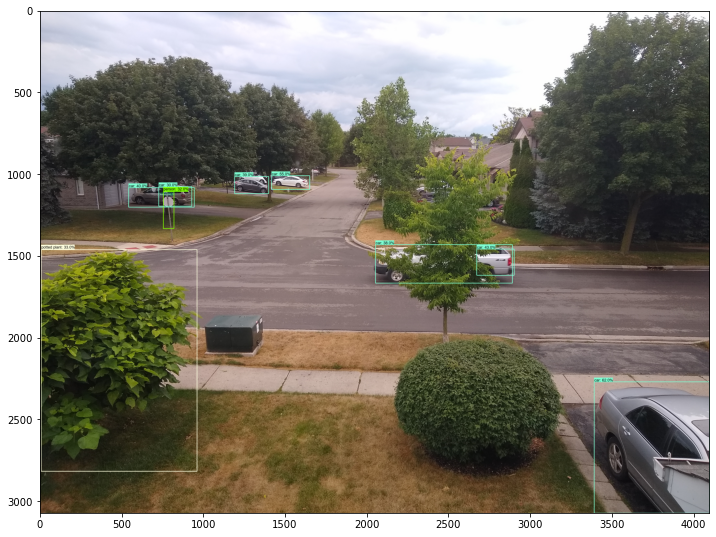

In [82]:
image_detection = image.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
        image_detection,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)+1,
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=.30)

plt.figure(figsize=(12,16))
plt.imshow(image_detection)
plt.imsave("image_with_annotations.jpg", image_detection)
plt.show()

### Retraining the model

In [83]:
print(list(detection_model.trainable_variables))

[<tf.Variable 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0' shape=(3, 3, 256, 24) dtype=float32, numpy=
array([[[[-3.75204510e-03,  2.12645694e-03, -7.88528996e-04, ...,
           5.74979465e-03,  5.15397685e-03,  2.46239756e-03],
         [-8.12177733e-03,  7.69745931e-03,  1.19231651e-02, ...,
           3.53496289e-03, -7.15895847e-04,  1.99782290e-03],
         [-5.08191576e-03,  2.01194384e-03,  2.29600072e-03, ...,
          -2.89358129e-03, -1.29042761e-02, -2.93601933e-03],
         ...,
         [-1.02838839e-03,  2.85689789e-03, -1.25877734e-03, ...,
          -4.44154302e-03, -4.84376354e-03, -2.84051197e-03],
         [ 6.00280182e-04,  1.69787707e-03,  9.56648029e-04, ...,
           4.62148928e-05,  7.42909673e-04, -1.73382473e-03],
         [ 4.48366860e-03,  3.90565116e-03, -4.52737004e-04, ...,
           6.26642862e-03, -6.12588774e-05, -5.75471902e-03]],

        [[ 1.03066461e-02,  5.89063112e-03, -6.75310707e-03, ..

In [8]:
images, boxes, cls_gt = read_image('PennFudanPed/PennFudanPed/PNGImages','PennFudanPed/PennFudanPed/PedMasks')
image_t, box_t, cls_t = prepare_data(images,boxes,cls_gt,1)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in detection_model.trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

In [12]:
train_fn = get_train_function(detection_model, optimizer, to_fine_tune)

train_model(train_fn,image_t, box_t, cls_t,10,10)

170
starting


KeyboardInterrupt: 

In [6]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Display the resulting frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
